<a href="https://colab.research.google.com/github/Samy-Annasri/genetic_algorithm_adv/blob/main/genetic_algorithm_adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
import sys
import os

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    repo_name = "genetic_algorithm_adv"
    ipynb_name = "genetic_algorithm_adv.ipynb"
    cwd = os.getcwd()
    basename = os.path.basename(cwd)

    if basename != repo_name:
        if not os.path.exists(repo_name):
            !git clone https://github.com/Samy-Annasri/genetic_algorithm_adv.git
        %cd {repo_name}
        %rm {ipynb_name}



In [5]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')

In [6]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
val_loader = result['val_loader']
test_loader = result['test_loader']
train_size = result['train_size']
val_size = result['val_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']


/content/genetic_algorithm_adv/utils/setup_google_stock_dataset.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X)  # Shape: (N, sequence_length, num_features)


In [7]:
from utils.train_with_validation import train_model_with_validation
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.01)
num_epochs = 10
train_model_with_validation(model_google, loss_fn, optimizer, num_epochs, train_loader, val_loader,sequence_length)

Epoch [1/10], Train Loss: 0.0573, Validation Loss: 0.0063
Epoch [2/10], Train Loss: 0.0032, Validation Loss: 0.0010
Epoch [3/10], Train Loss: 0.0015, Validation Loss: 0.0008
Epoch [4/10], Train Loss: 0.0012, Validation Loss: 0.0008
Epoch [5/10], Train Loss: 0.0013, Validation Loss: 0.0021
Epoch [6/10], Train Loss: 0.0011, Validation Loss: 0.0008
Epoch [7/10], Train Loss: 0.0011, Validation Loss: 0.0006
Epoch [8/10], Train Loss: 0.0010, Validation Loss: 0.0007
Epoch [9/10], Train Loss: 0.0009, Validation Loss: 0.0007
Epoch [10/10], Train Loss: 0.0011, Validation Loss: 0.0006


In [8]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size, val_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [9]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM']
metrics = ['MAE', "RMSE", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA', 'GEN']
epsilons = {
    'NA': [0],
    'GEN': [0.01, 0.1, 0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA  GEN          
ε            0.00 0.01 0.10 0.20
Model Metric                    
LSTM  MAE     NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN


In [10]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator



LSTM | NA – Epsilon 0.00 – MAE: 2.4894 | SIM: 0.9997


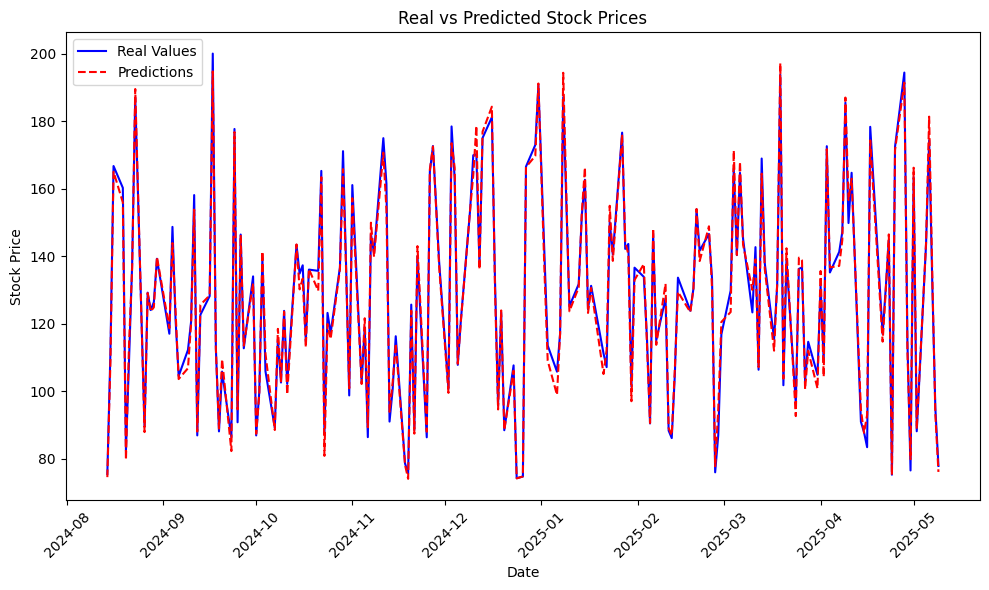

In [11]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [12]:
display(res_tab)

Attack              NA  GEN          
ε                 0.00 0.01 0.10 0.20
Model Metric                         
LSTM  MAE     2.489437  NaN  NaN  NaN
      RMSE    3.173802  NaN  NaN  NaN
      SIM     0.999711  NaN  NaN  NaN

## naive implementation gen_adv

LSTM | GEN – Epsilon 0.01 – MAE: 2.5170 | SIM: 0.9997


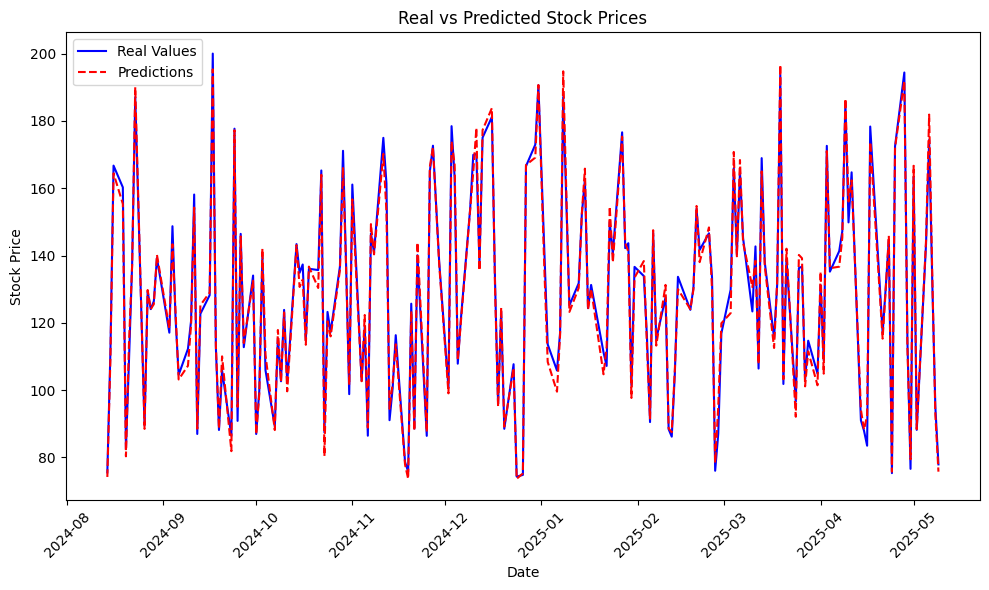

LSTM | GEN – Epsilon 0.10 – MAE: 5.4611 | SIM: 0.9989


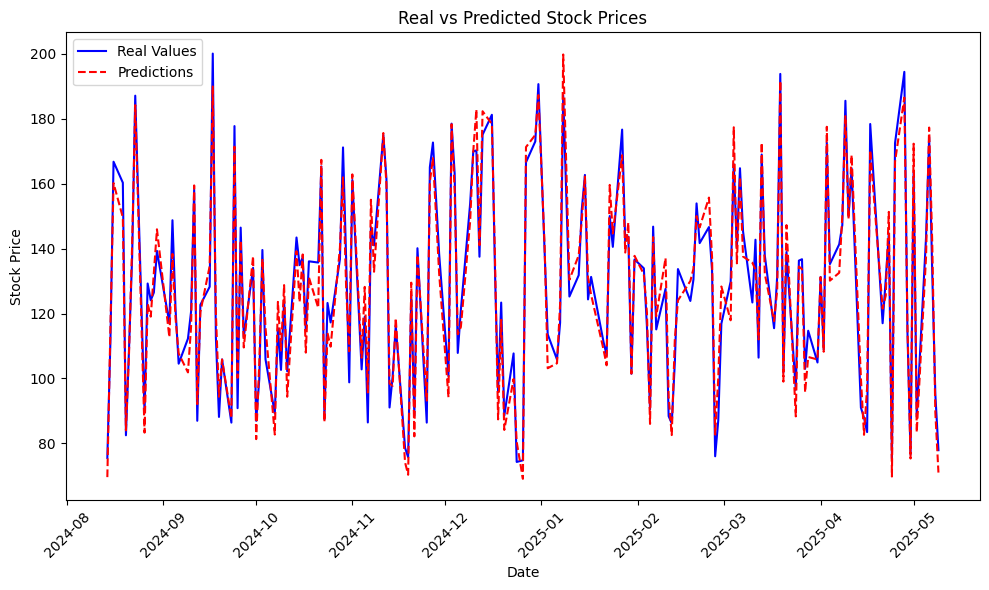

LSTM | GEN – Epsilon 0.20 – MAE: 11.1507 | SIM: 0.9960


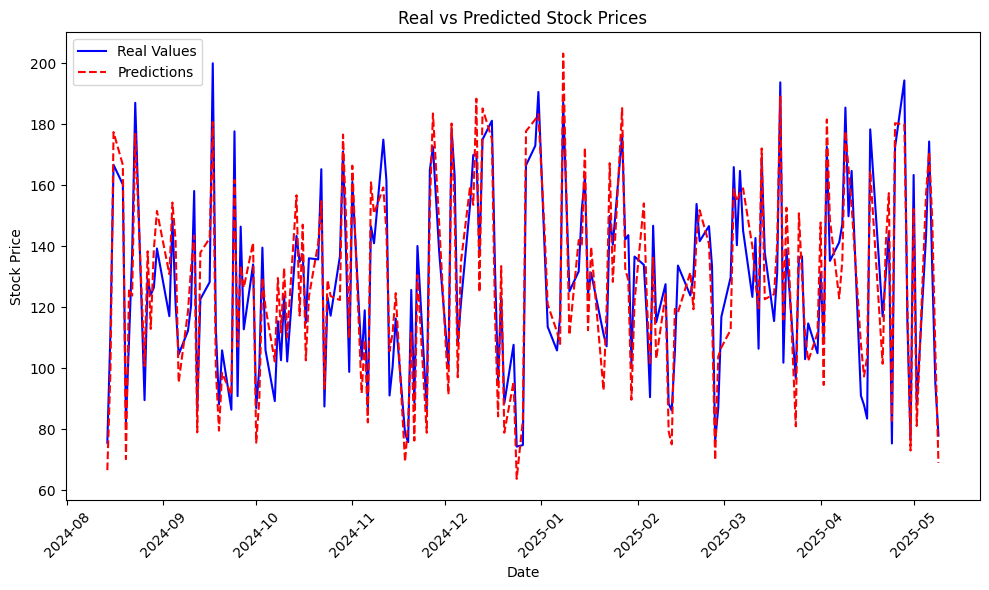

In [13]:
from gen_adv.attack import genetic_attack
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_google.to(device)

epsilons = [0.01, 0.1, 0.2]

for esp in epsilons:
    adversarial_preds = []
    true_vals = []

    for X_batch, y_batch in test_loader:
        for i in range(len(X_batch)):
            X = X_batch[i].to(device)
            y = y_batch[i].item()
            X_adv = genetic_attack(model_google, X, epsilon=esp, device=device)
            with torch.no_grad():
                pred = model_google(X_adv.unsqueeze(0)).item()
            adversarial_preds.append(pred)
            true_vals.append(y)

    adv_preds = np.array(adversarial_preds)
    true_vals = np.array(true_vals)

    # Denormalisation
    true_vals_denorm = true_vals * (price_max - price_min) + price_min
    adv_preds_denorm = adv_preds * (price_max - price_min) + price_min

    mae_adv = mean_absolute_error(true_vals_denorm, adv_preds_denorm)
    rmse_adv = np.sqrt(mean_squared_error(true_vals_denorm, adv_preds_denorm))
    sim_adv = scalar_similarity(true_vals_denorm, adv_preds_denorm)

    res_tab.loc[("LSTM", "MAE"), ("GEN", esp)] = mae_adv
    res_tab.loc[("LSTM", "RMSE"), ("GEN", esp)] = rmse_adv
    res_tab.loc[("LSTM", "SIM"), ("GEN", esp)] = sim_adv

    log_and_plot_predictions(
        true_values=true_vals_denorm,
        predictions=adv_preds_denorm,
        test_dates=test_dates,
        true_values_rolling=None,
        predictions_rolling=None,
        model_name='LSTM',
        attack_name='GEN',
        epsilon=esp,
        res_tab=res_tab,
        similarity_fn=scalar_similarity,
        google=True
    )


In [14]:
display(res_tab)

Attack              NA       GEN                                           \
ε                 0.00      0.01      0.10       0.20      0.01       0.1   
Model Metric                                                                
LSTM  MAE     2.489437  2.516951  5.461082  11.150748  2.516951  5.461082   
      RMSE    3.173802  3.185576  6.269584  11.787628  3.185576  6.269584   
      SIM     0.999711  0.999709  0.998866   0.996008  0.999709  0.998866   

Attack                   
ε                   0.2  
Model Metric             
LSTM  MAE     11.150748  
      RMSE    11.787628  
      SIM      0.996008